In [1]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *      

In [2]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children') #enter the YK_util file directory
import YK_util, optimized_pair_comparison
from YK_util import *
from optimized_pair_comparison import *

In [3]:
#initiate the dataset, select monocytes in kids only
path = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = getdata(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p
adata_kid = removegenes(adata_kid)
adata_kid = normalizedata(adata_kid, log1p=False) # didn't log1p

adata_kid_M = adata_kid[adata_kid.obs.cell_type == 'Monocytes'] # remove 'IGHG1', 'MZB'
adata_kid_M = remove2genes(adata_kid_M)
sc.pp.filter_genes(adata_kid_M, min_cells=3)

In [ ]:
#pair comparison generation for kids
cts = adata_kid.obs['cell_type'].unique().tolist()
pair = pair_comparison(adata_kid, cts, log1p=2)

pair['pair_res'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/log2FC.tsv', sep='\t')

fra_av = fra_avg(adata_kid, cts, log1p=2)
fra_av['fra'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/fra.tsv', sep='\t', index=False)
fra_av['avg'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/avg.tsv', sep='\t', index=False)

data = combination(pair['pair_res'], fra_av['fra'], fra_av['avg'])
data.to_csv('/home/yike/phd/dengue/data/tables/cell_type/data_pair.tsv', sep='\t')

In [ ]:
#pair comparison generation for kids monocyte subtype
csts = adata_kid.obs['cell_subtype_2'].unique().tolist()
csts.remove('doublets')
csts.remove('pDCs')
pair = pair_comparison(adata_kid, csts, log1p=2)

pair['pair_res'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/log2FC.tsv', sep='\t')

fra_av = fra_avg(adata_kid, csts, log1p=2)
fra_av['fra'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/fra.tsv', sep='\t', index=False)
fra_av['avg'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/avg.tsv', sep='\t', index=False)

data = combination(pair['pair_res'], fra_av['fra'], fra_av['avg'])
data.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/data_pair.tsv', sep='\t')

In [ ]:
import anndataks
subcts = cts + csts
conditions = ['S_dengue', 'dengue']

results = {}
for subct in subcts:
    if subct in adata_kid.obs['cell_type'].astype('category').cat.categories:
        adata_ct = adata_kid[adata_kid.obs['cell_type'] == subct]
    elif subct in adata_kid.obs['cell_subtype_2'].astype('category').cat.categories:
        adata_ct = adata_kid[adata_kid.obs['cell_subtype_2'] == subct]
        
    adata_SD = adata_ct[adata_ct.obs['Condition'] == 'S_dengue']
    adata_D = adata_ct[adata_ct.obs['Condition'] == 'dengue']
    # while calculating ks test pvalue, the adata is log1ped, so the argument log1p=2
    results[subct] = anndataks.compare(adata_D, adata_SD, log1p=2) # log2_fold_change: adata_Sd vs adata_D

ks_res = pd.DataFrame([])
for subct in subcts:
    results[subct]['cell_subtype'] = [subct] * results[subct].shape[0]
    ks_res = pd.concat([ks_res, results[subct]])

ks_res.set_index(['cell_subtype', ks_res.index], inplace=True)
ks_res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ks_pvalue.tsv', sep='\t')

ks_res = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ks_pvalue.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
im_subct = pd.concat([im_subct, ks_res.loc[im_subct.index]], axis=1)
im_subct.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/data_pair_p.tsv', sep='\t')

im_ct = pd.concat([im_ct, ks_res.loc[im_ct.index]], axis=1)
im_ct.to_csv('/home/yike/phd/dengue/data/tables/cell_type/data_pair_p.tsv', sep='\t')

In [2]:
subct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/mo/data_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/mo/data_pair.tsv', sep='\t',  index_col=['cell_subtype', 'gene'])

In [554]:
def scatter_plot(data, name, genes, ylim=200, xlim=3):
    from adjustText import adjust_text
    
    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (-np.log10(data['pvalue']) > 2)
    data_r = data[req]
    data_b = data[~ req]
    
    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ax.scatter(data_b['log2_fold_change'].tolist(), -np.log10(data_b['pvalue'].tolist()), c='gray', s=1)
    ax.scatter(data_r['log2_fold_change'].tolist(), -np.log10(data_r['pvalue'].tolist()), c='blue', s=1)
    
#     for x, y, gene in zip(data_r['log2_fold_change'].tolist(), -np.log10(data_r['pvalue'].tolist()), data_r.index):
#         ax.text(x, y, gene, c='black', fontsize=6)

    texts = [ax.text(x, y, gene, c='black', fontsize=4) for x, y, gene in zip(data.loc[genes]['log2_fold_change'].tolist(), 
                                                                              -np.log10(data.loc[genes]['pvalue'].tolist()), 
                                                                              genes)]
    adjust_text(texts)
    
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-5, ylim)
    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5)
    #ax.axhline(2, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.set_xlabel('log2 fold change')
    ax.set_ylabel('-log10P')
    ax.set_title('%s (SD vs D)'%name.replace('_', ' '))
    
    genes = data_r.index.tolist()
    return {'fig': fig, 'ax': ax, 'genes': genes}

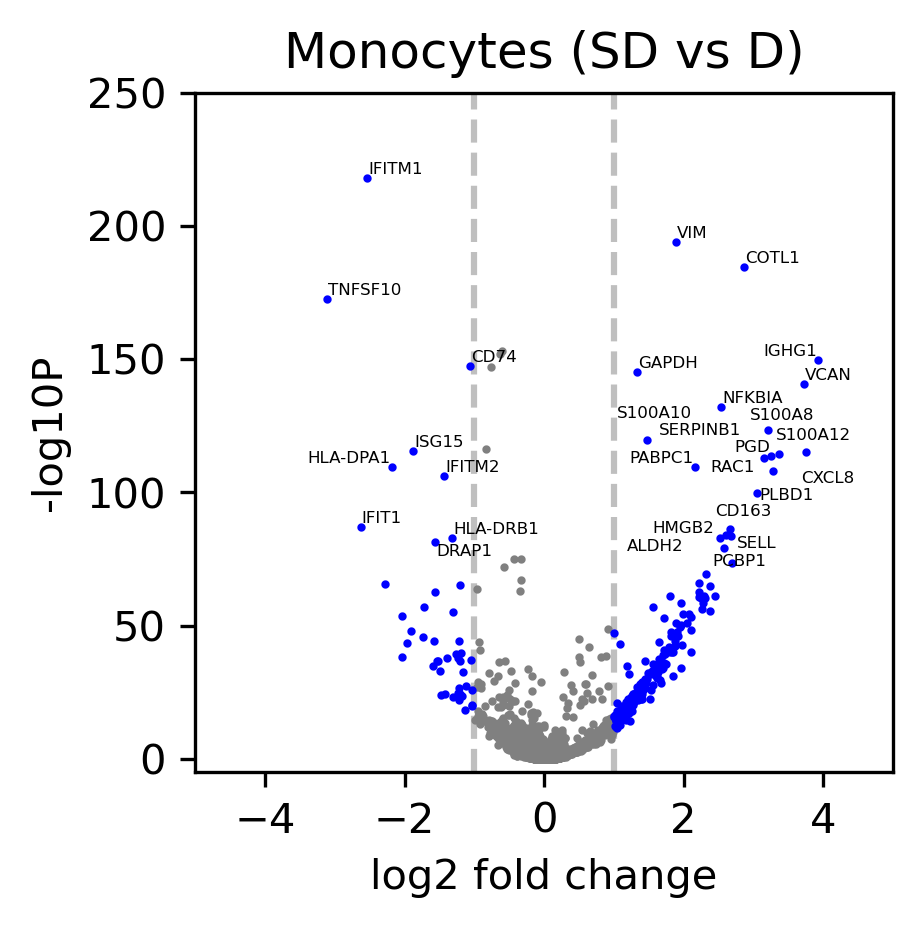

In [555]:
fn = '/home/yike/phd/dengue/figures/luca_endothelial/'

data =  ct.loc['Monocytes'][(ct.loc['Monocytes']['log2_fold_change'] > 1) | (ct.loc['Monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 75].index.tolist()
m_dt = scatter_plot(ct.loc['Monocytes'], 'Monocytes', genes, ylim=250, xlim=5)
m_dt['fig'].savefig(fn + 'monocytes.png', bbox_inches='tight')

In [ ]:
# mo_ct.sort_values('med_pair', ascending=False, inplace=True)
# mo_subct.sort_values('med_pair', ascending=False, inplace=True)
# ct_cond = ((mo_ct['med_pair'] > 1) & (mo_ct['S_fra'] > 0.02)) | ((mo_ct['med_pair'] < -1) & (mo_ct['NS_fra'] > 0.02)) 
# subct_cond = ((mo_subct['med_pair'] > 1) & (mo_subct['S_fra'] > 0.02)) | ((mo_subct['med_pair'] < -1) & (mo_subct['NS_fra'] > 0.02)) 

# ct_filter = mo_ct.loc[ct_cond]
# subct_filter = mo_subct.loc[subct_cond]

# ct_filter.to_csv('/home/yike/phd/dengue/data/tables/cell_type/data_pair_filter.tsv', sep='\t')
# subct_filter.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/data_pair_filter.tsv', sep='\t')

# ct_filter = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/data_pair_filter.tsv', sep='\t', index_col=['gene'])
# subct_filter = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/data_pair_filter.tsv', sep='\t', index_col=['cell_subtype_2', 'gene'])

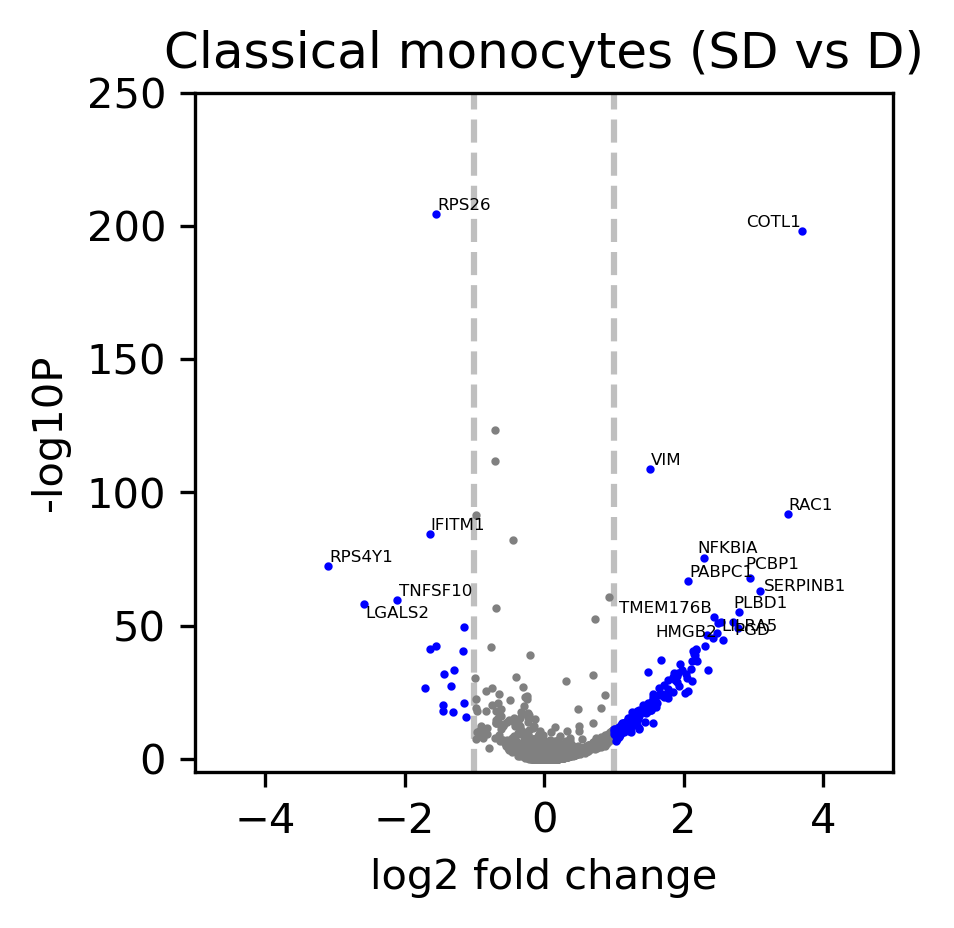

In [470]:
fn = '/home/yike/phd/dengue/figures/luca_endothelial/'

data =  subct.loc['Classical_monocytes'][(subct.loc['Classical_monocytes']['log2_fold_change'] > 1) | (subct.loc['Classical_monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 50].index.tolist()
m_dt = scatter_plot(subct.loc['Classical_monocytes'], 'Classical_monocytes', genes, ylim=250, xlim=5)
m_dt['fig'].savefig(fn + 'Classical_monocytes.png', bbox_inches='tight')

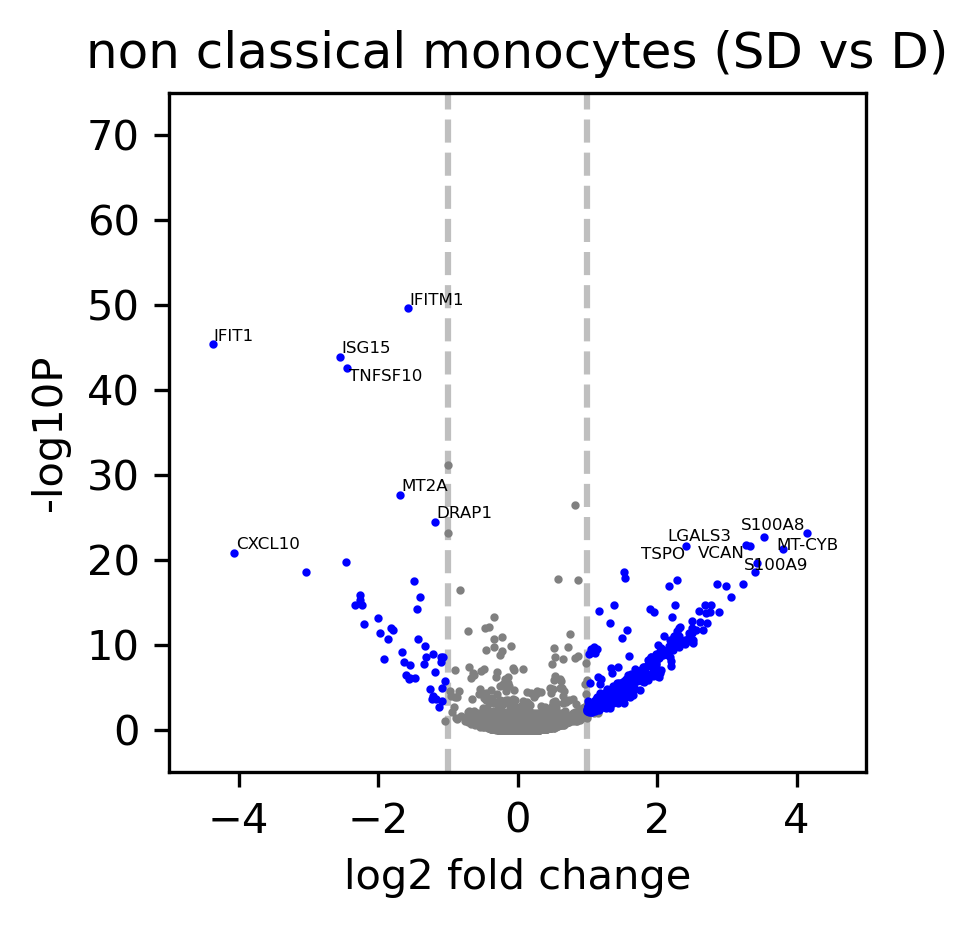

In [471]:
data =  subct.loc['non_classical_monocytes'][(subct.loc['non_classical_monocytes']['log2_fold_change'] > 1) | 
                                             (subct.loc['non_classical_monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 20].index.tolist()
m_dt = scatter_plot(subct.loc['non_classical_monocytes'], 'non_classical_monocytes', genes, ylim=75, xlim=5)
m_dt['fig'].savefig(fn + 'non_classical_monocytes.png', bbox_inches='tight')

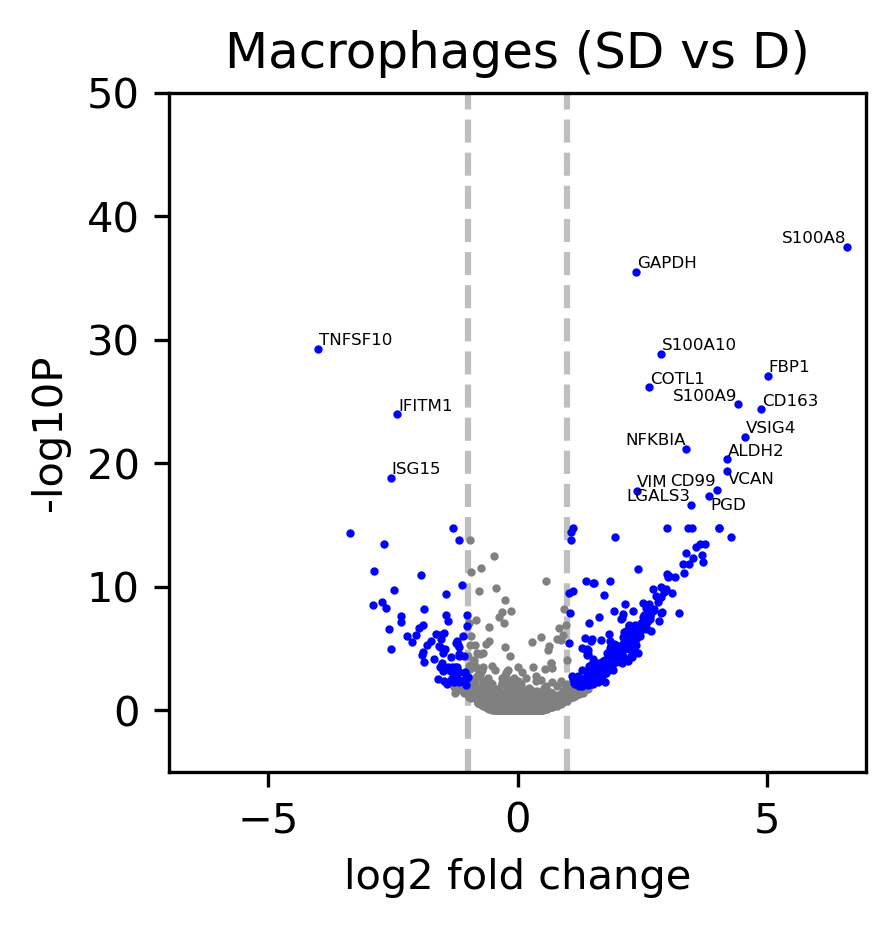

In [472]:
data =  subct.loc['Macrophages'][(subct.loc['Macrophages']['log2_fold_change'] > 1) |
                                         (subct.loc['Macrophages']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 15].index.tolist()
m_dt = scatter_plot(subct.loc['Macrophages'], 'Macrophages', genes, ylim=50, xlim=7)
m_dt['fig'].savefig(fn + 'Macrophages.png', bbox_inches='tight')

In [473]:
def scatter_with_inters(data, name, genes, it_genes, ylim=200, xlim=3):
    from adjustText import adjust_text
    
    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (-np.log10(data['pvalue']) > 2)
    data_r = data[req]
    data_b = data[~ req]
    
    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ax.scatter(data_b['log2_fold_change'].tolist(), -np.log10(data_b['pvalue'].tolist()), c='gray', s=1)
    ax.scatter(data_r['log2_fold_change'].tolist(), -np.log10(data_r['pvalue'].tolist()), c='blue', s=1)

    all_gs = np.unique(genes + it_genes)
    texts = [ax.text(x, y, gene, c='black', fontsize=4) for x, y, gene in zip(data.loc[all_gs]['log2_fold_change'].tolist(), 
                                                                              -np.log10(data.loc[all_gs]['pvalue'].tolist()), 
                                                                              all_gs)]
    adjust_text(texts)
    ax.scatter(data.loc[it_genes]['log2_fold_change'].tolist(), 
               -np.log10(data.loc[it_genes]['pvalue'].tolist()), c='red', s=3)
    
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-5, ylim)
    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.set_xlabel('log2 fold change')
    ax.set_ylabel('-log10P')
    ax.set_title('%s (SD vs D)'%name.replace('_', ' '))
    
    genes = data_r.index.tolist()
    return {'fig': fig, 'ax': ax, 'genes': genes}

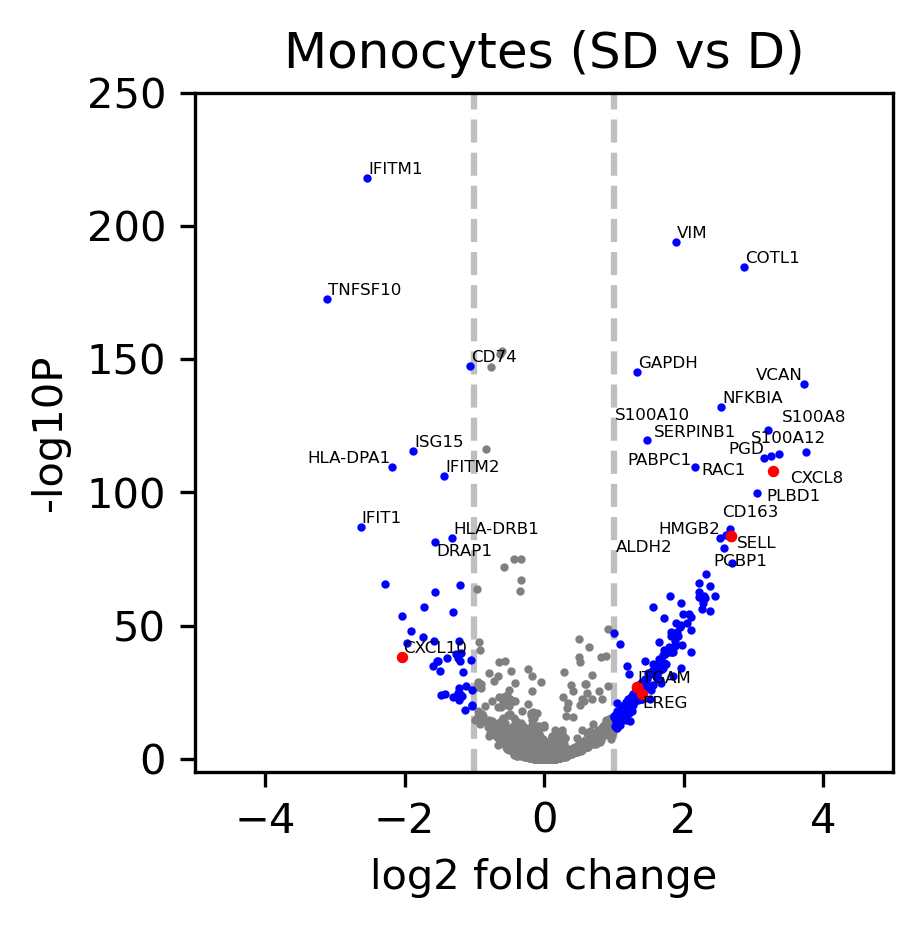

In [479]:
fn = '/home/yike/phd/dengue/figures/luca_endothelial/'

data =  ct.loc['Monocytes'][(ct.loc['Monocytes']['log2_fold_change'] > 1) | (ct.loc['Monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 75].index.tolist()
it_genes = cts_ave_2.loc['Monocytes'].index.tolist()
m_dt = scatter_with_inters(ct.loc['Monocytes'], 'Monocytes', genes, it_genes, ylim=250, xlim=5)
m_dt['fig'].savefig(fn + 'monocytes1.png', bbox_inches='tight')

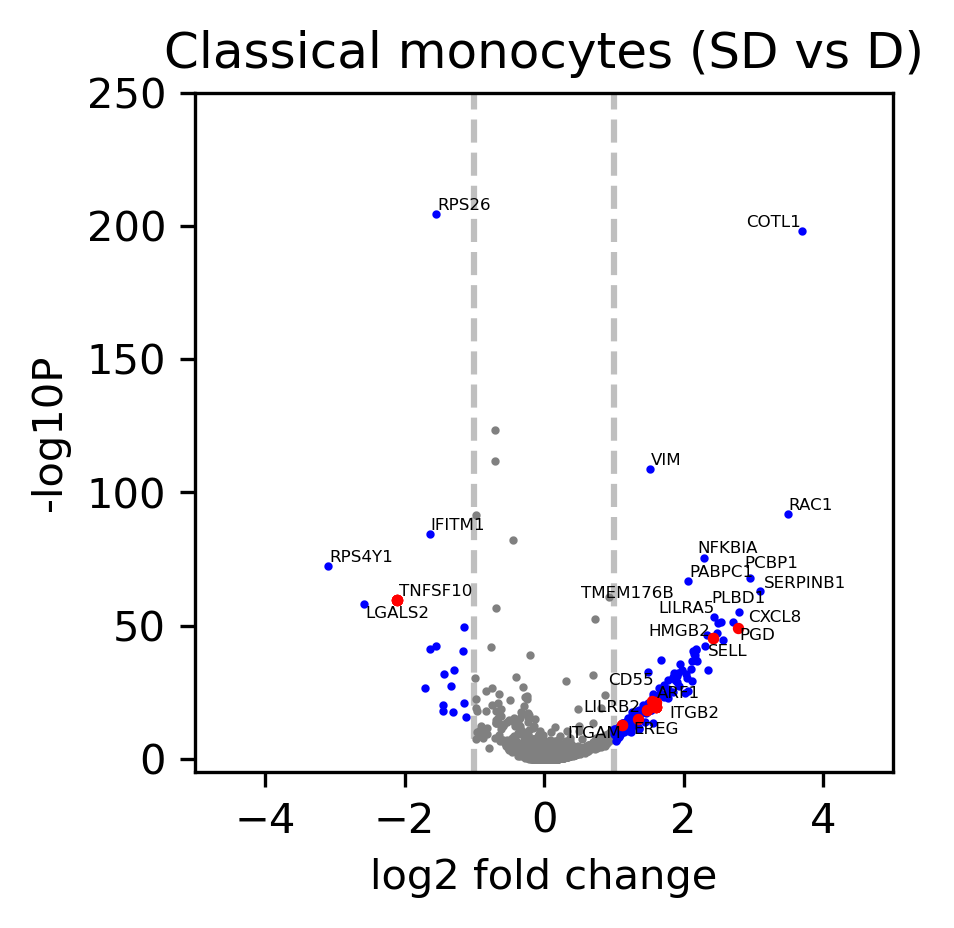

In [480]:
fn = '/home/yike/phd/dengue/figures/luca_endothelial/'

data =  subct.loc['Classical_monocytes'][(subct.loc['Classical_monocytes']['log2_fold_change'] > 1) | (subct.loc['Classical_monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 50].index.tolist()
it_genes = csts_ave_2.loc['Classical_monocytes'].index.tolist()
m_dt = scatter_with_inters(subct.loc['Classical_monocytes'], 'Classical_monocytes', genes, it_genes, ylim=250, xlim=5)
m_dt['fig'].savefig(fn + 'Classical_monocytes1.png', bbox_inches='tight')

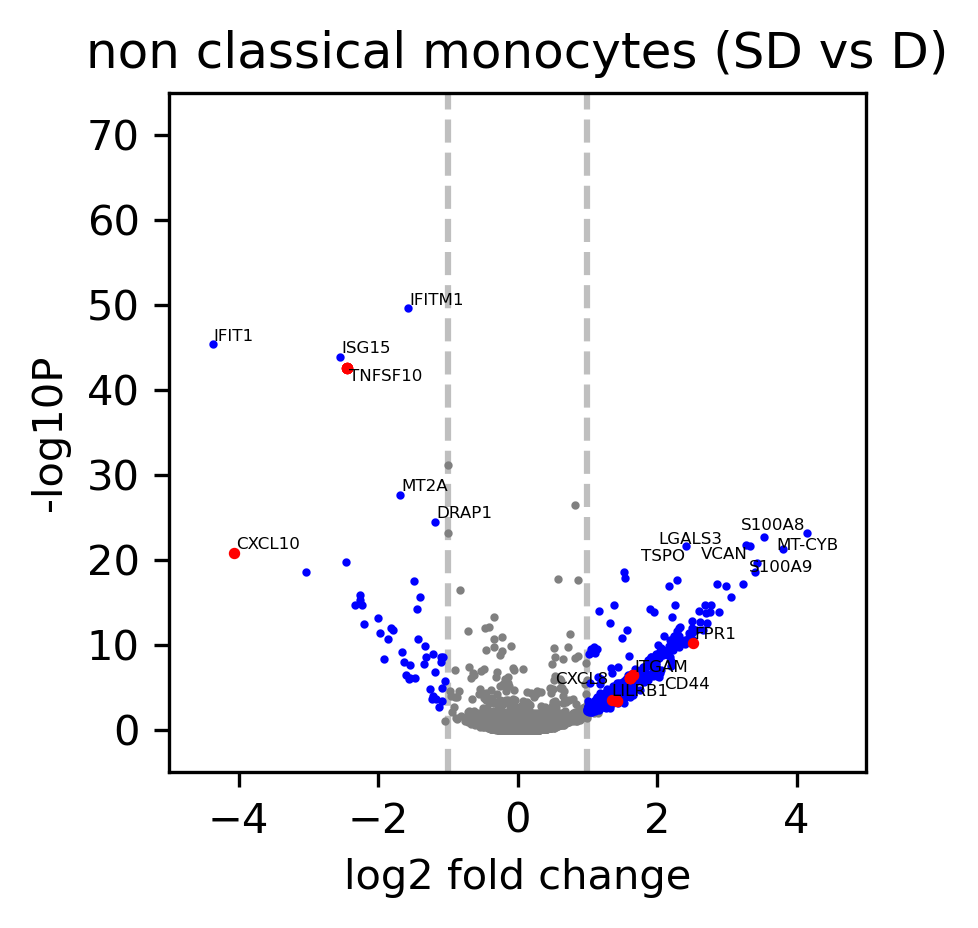

In [481]:
data =  subct.loc['non_classical_monocytes'][(subct.loc['non_classical_monocytes']['log2_fold_change'] > 1) | 
                                             (subct.loc['non_classical_monocytes']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 20].index.tolist()
it_genes = csts_ave_2.loc['non_classical_monocytes'].index.tolist()
m_dt = scatter_with_inters(subct.loc['non_classical_monocytes'], 'non_classical_monocytes', genes, it_genes, ylim=75, xlim=5)
m_dt['fig'].savefig(fn + 'non_classical_monocytes1.png', bbox_inches='tight')

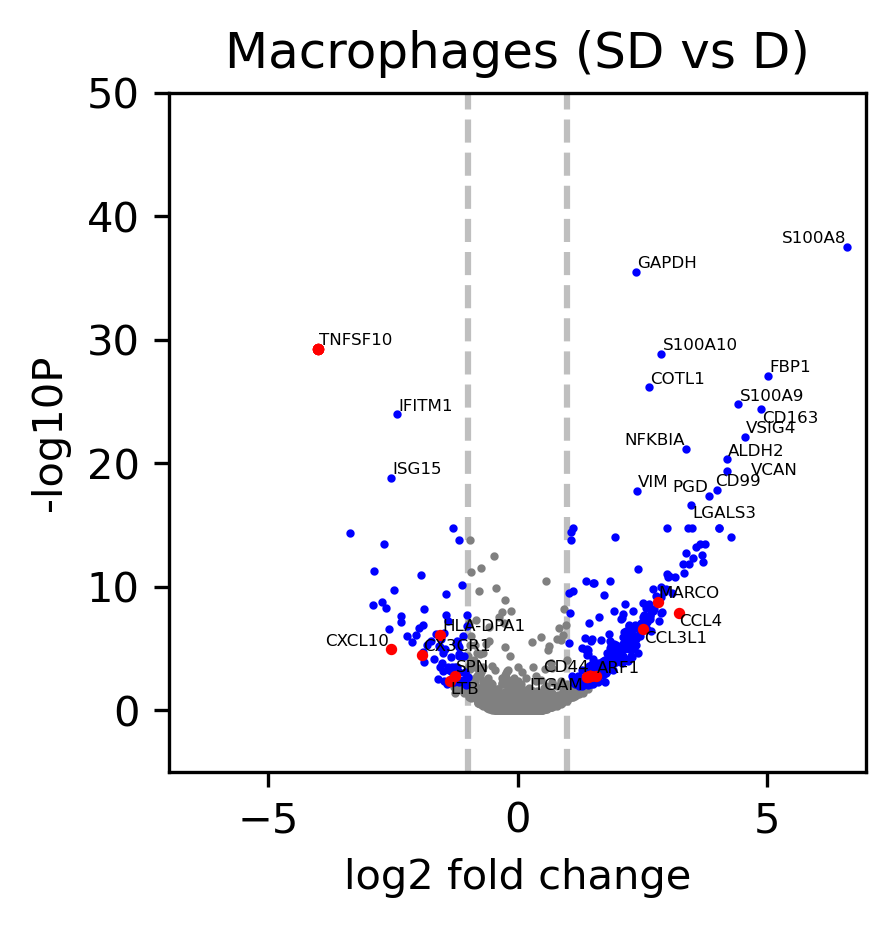

In [482]:
data =  subct.loc['Macrophages'][(subct.loc['Macrophages']['log2_fold_change'] > 1) |
                                         (subct.loc['Macrophages']['log2_fold_change'] < -1)]
genes = data[-np.log10(data['pvalue']) > 15].index.tolist()
it_genes = csts_ave_2.loc['Macrophages'].index.tolist()
m_dt = scatter_with_inters(subct.loc['Macrophages'], 'Macrophages', genes, it_genes, ylim=50, xlim=7)
m_dt['fig'].savefig(fn + 'Macrophages1.png', bbox_inches='tight')

In [508]:
def scatter_with_ed(data, name, inter_df, ylim=200, xlim=3):
    
    from adjustText import adjust_text

    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (-np.log10(data['pvalue']) > 2)
    data_r = data[req]
    data_b = data[~ req]

    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ax.scatter(data_b['log2_fold_change'].tolist(), -np.log10(data_b['pvalue'].tolist()), c='gray', s=1)
    ax.scatter(data_r['log2_fold_change'].tolist(), -np.log10(data_r['pvalue'].tolist()), c='blue', s=1)

    inter_df.reset_index(inplace=True)
    inter_df.set_index(['cta', 'ga'], inplace=True)

    mark_x = []
    mark_y = []
    mark_t = []

    for (cta, ga) in inter_df.index.unique():
        if cta == name:
            mark_x.append(data.loc[ga]['log2_fold_change'])
            mark_y.append(-np.log10(data.loc[ga]['pvalue']))

            ed_gs = inter_df.loc[(cta, ga)]['gb'].tolist()

            pt = ga + '->'
            for g in ed_gs:
                if g in ed_gs[: -1]:
                    pt += g + ',\n'
                else:
                    pt += g
            mark_t.append(pt)

    ax.scatter(mark_x, mark_y, c='red', s=3)
    texts = [ax.text(x, y, gene, c='black', fontsize=5) for x, y, gene in zip(mark_x, mark_y, mark_t)]
    adjust_text(texts)   

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-5, ylim)
    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5)
    #ax.axhline(2, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.set_xlabel('log2 fold change')
    ax.set_ylabel('-log10P')
    ax.set_title('%s (SD vs D)'%name.replace('_', ' '))
    
    genes = data_r.index.tolist()
    return {'fig': fig, 'ax': ax, 'genes': genes}

<ipython-input-508-6b48432b2f95>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  ed_gs = inter_df.loc[(cta, ga)]['gb'].tolist()


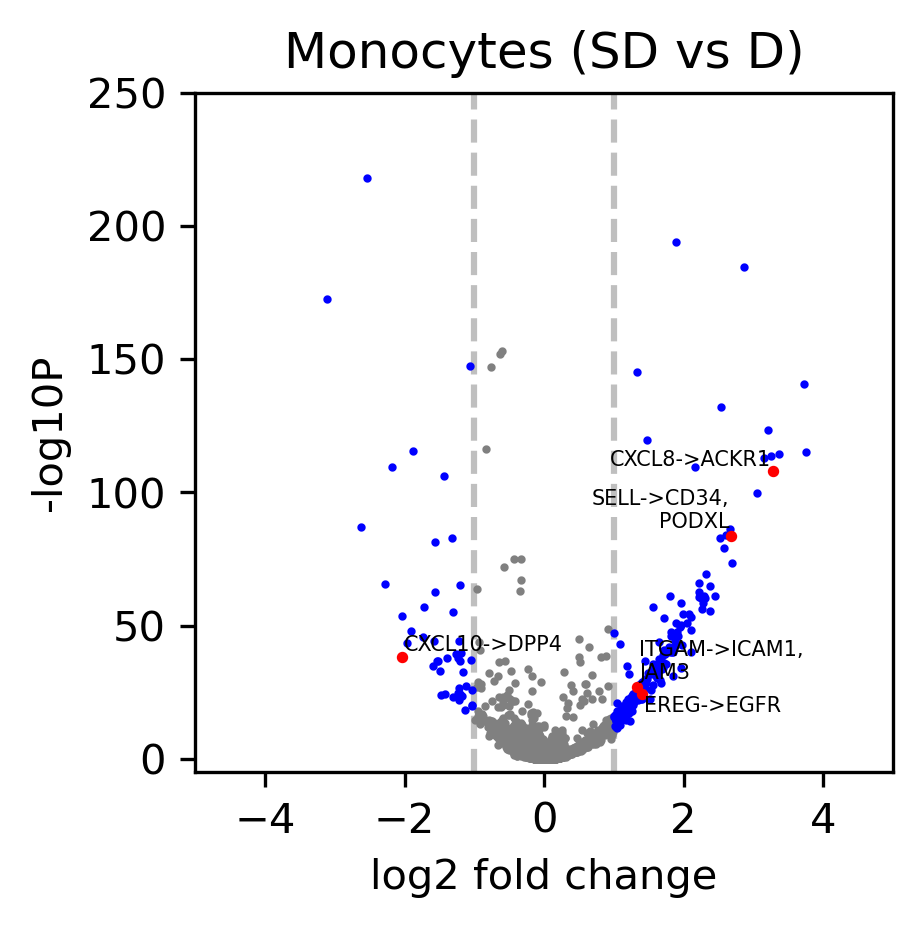

In [509]:
fn = '/home/yike/phd/dengue/figures/luca_endothelial/'
cm_dt = scatter_with_ed(ct.loc['Monocytes'], 'Monocytes', cts_ave_2, ylim=250, xlim=5)
cm_dt['fig'].savefig(fn + 'monocytes_inters.png', bbox_inches='tight')

<ipython-input-508-6b48432b2f95>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  ed_gs = inter_df.loc[(cta, ga)]['gb'].tolist()


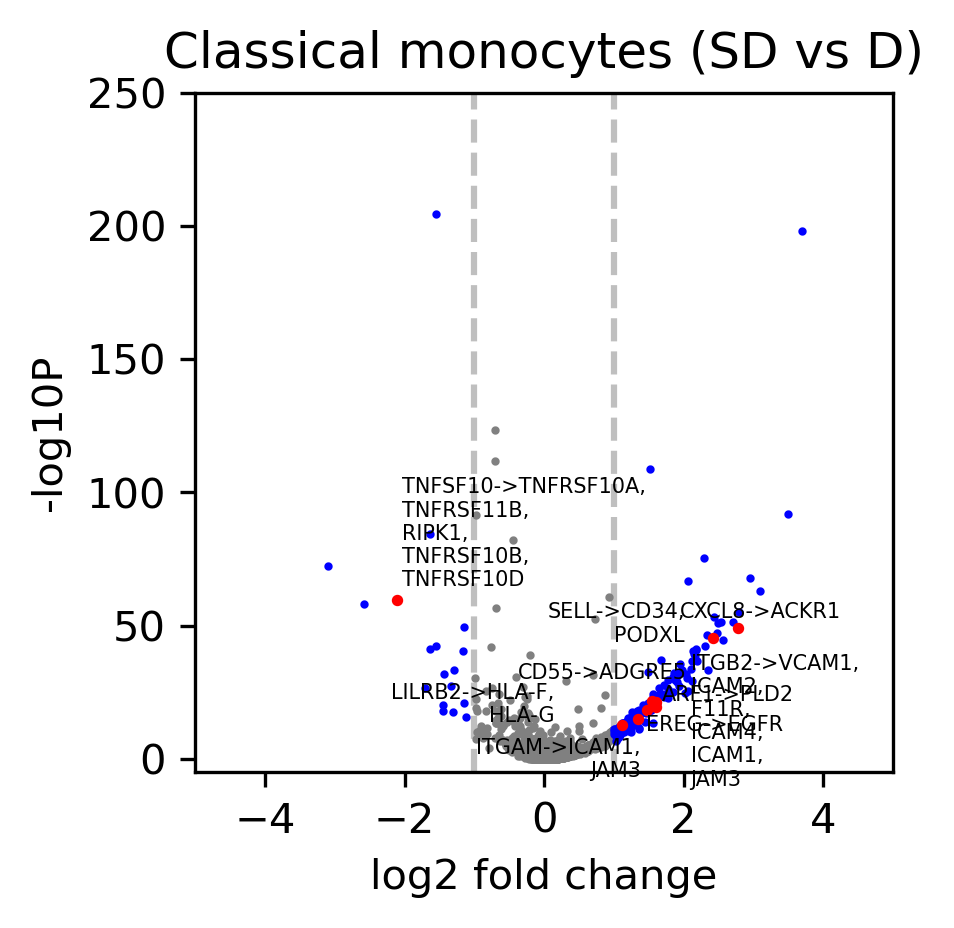

In [510]:
cm_dt = scatter_with_ed(subct.loc['Classical_monocytes'], 'Classical_monocytes', csts_ave_2, ylim=250, xlim=5)
cm_dt['fig'].savefig(fn + 'cmo_inters.png', bbox_inches='tight')

<ipython-input-508-6b48432b2f95>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  ed_gs = inter_df.loc[(cta, ga)]['gb'].tolist()


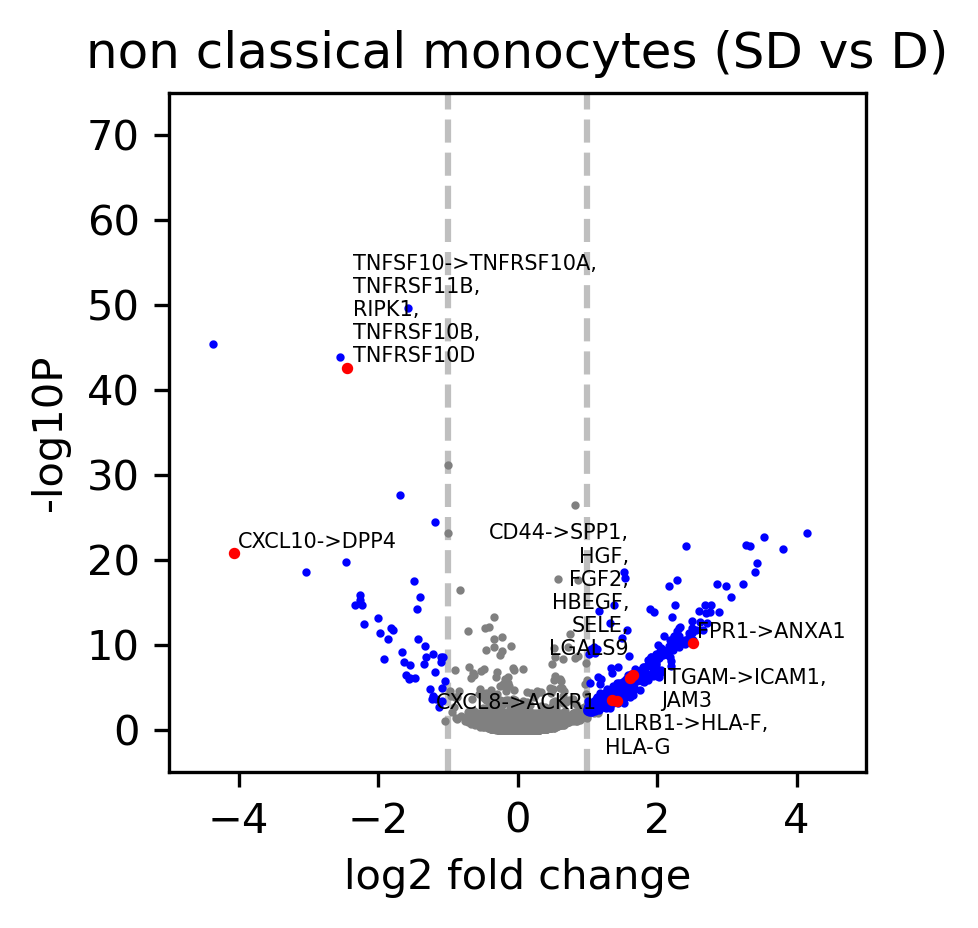

In [511]:
cm_dt = scatter_with_ed(subct.loc['non_classical_monocytes'], 'non_classical_monocytes', csts_ave_2, ylim=75, xlim=5)
cm_dt['fig'].savefig(fn + 'ncm_inters.png', bbox_inches='tight')

<ipython-input-508-6b48432b2f95>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  ed_gs = inter_df.loc[(cta, ga)]['gb'].tolist()


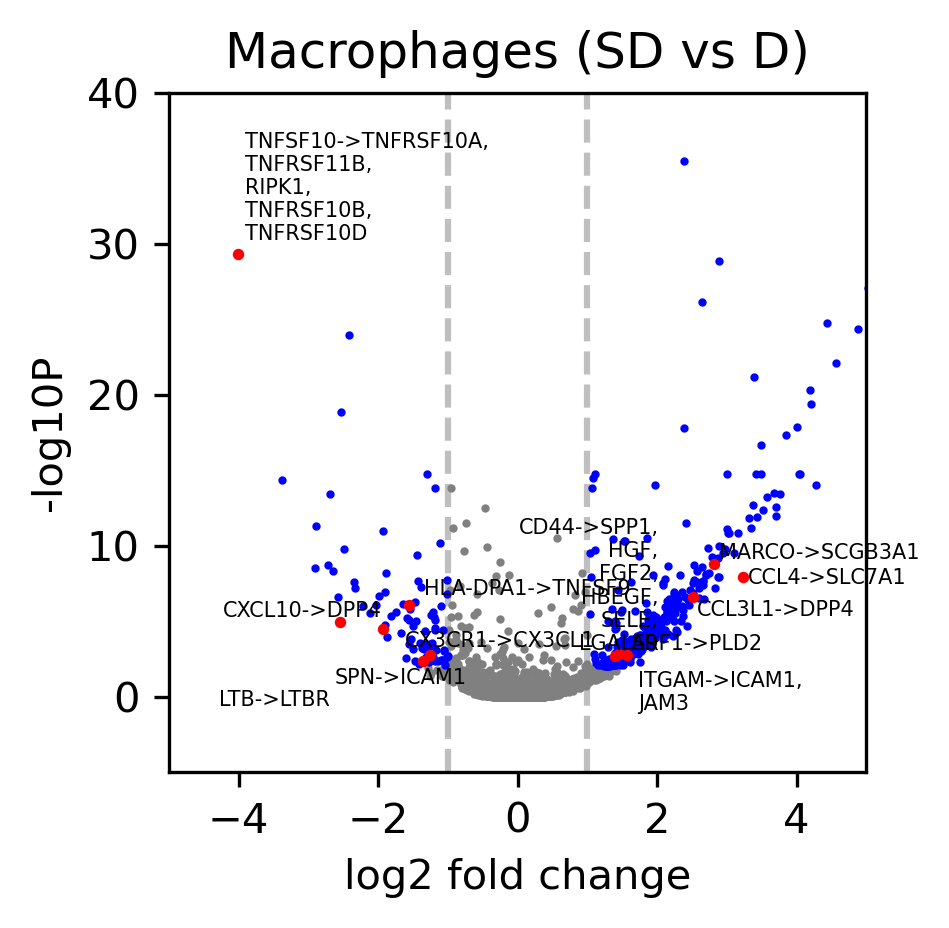

In [512]:
cm_dt = scatter_with_ed(subct.loc['Macrophages'], 'Macrophages', csts_ave_2, ylim=40, xlim=5)
cm_dt['fig'].savefig(fn + 'marco_inters.png', bbox_inches='tight')

In [313]:
def scatter_with_cst(data, name, inter_df, ylim=200, xlim=3):
    
    from adjustText import adjust_text

    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (-np.log10(data['pvalue']) > 2)
    data_r = data[req]
    data_b = data[~ req]

    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ax.scatter(data_b['log2_fold_change'].tolist(), -np.log10(data_b['pvalue'].tolist()), c='gray', s=1)
    ax.scatter(data_r['log2_fold_change'].tolist(), -np.log10(data_r['pvalue'].tolist()), c='blue', s=1)

    a = inters_cst.loc[('Macrophages', 'EREG', 'EGFR')]['ctb'].tolist()
    o = ['capillary aerocyte',
         'capillary endothelial cell',
         'endothelial cell',
         'endothelial cell of artery',
         'endothelial cell of lymphatic vessel',
         'endothelial cell of vascular tree',
         'gut endothelial cell',
         'lung microvascular endothelial cell',
         'vein endothelial cell']
    n = ['capillary',
        'capillary',
        '',
        'arterial',
        'lymphatic',
        'vascular tree'
        'gut',
        'lung microvascular',
        'venous']
    dic = {a : b for a, b in zip(o, n)}

    inter_df.reset_index(inplace=True)
    inter_df.set_index(['cta', 'ga', 'gb'], inplace=True)

    mark_x = []
    mark_y = []
    mark_t = []

    for (cta, ga, gb) in inter_df.index.unique():
        mark_x.append(data.loc[ga]['log2_fold_change'])
        mark_y.append(-np.log10(data.loc[ga]['pvalue']))

        ed_cts = inter_df.loc[(cta, ga, gb)]['ctb'].tolist()
        tt = np.unique([value for key, value in dic.items() if key in ed_cts])

        pt = ga + ' interacts with ' + gb + ' in \n'
        for c in tt:
            if c == '':
                continue
            if c in tt[: -1]:
                pt += c + ',\n'
            else:
                pt += c
        pt = pt + ' endothelial cells'
        mark_t.append(pt)

    ax.scatter(mark_x, mark_y, c='red', s=3)
    texts = [ax.text(x, y, gene, c='black', fontsize=4) for x, y, gene in zip(mark_x, mark_y, mark_t)]
    adjust_text(texts)   

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-5, 250)
    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.axhline(2, zorder=-5, ls='--', c='gray', alpha=0.5)
    ax.set_xlabel('log2 fold change')
    ax.set_ylabel('-log10P')
    ax.set_title('%s (SD vs D)'%name)
    
    genes = data_r.index.tolist()
    return {'fig': fig, 'ax': ax, 'genes': genes}

<ipython-input-313-06e5aa188d37>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  a = inters_cst.loc[('Macrophages', 'EREG', 'EGFR')]['ctb'].tolist()
<ipython-input-313-06e5aa188d37>:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  ed_cts = inter_df.loc[(cta, ga, gb)]['ctb'].tolist()


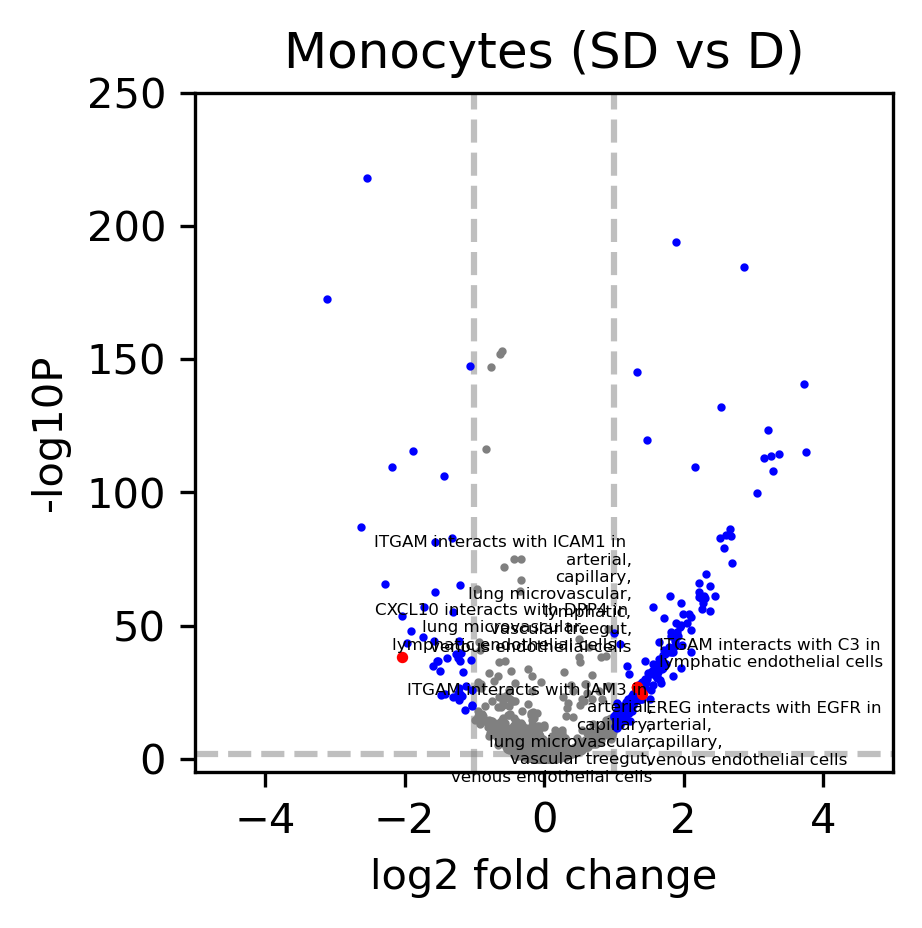

In [314]:
cm_dt = scatter_with_cst(ct.loc['Monocytes'], 'Monocytes', inters_ct, ylim=250, xlim=5)

In [386]:
ct_FC = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/mo/log2FC.tsv', sep='\t', index_col=0)
subct_FC = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/mo/log2FC.tsv', sep='\t', index_col=0)

In [501]:
def pairwise_boxplot(data, genes, title, path=False):
    box_data = data[genes]
    box_data = pd.melt(box_data)
    
    fig, ax = plt.subplots(dpi=300, figsize=[3, len(genes)*0.1])
    sns.boxplot(data = box_data, y = 'variable', x = 'value', orient = 'h', ax=ax)

    ax.set(xlabel = 'diff log2 fold change', ylabel = None, xlim = (-7.5, 7.5), title = title)
    
    if path is not False:
        fig.savefig(path, bbox_inches='tight')
        
    return {'figure': fig, 'ax': ax}

{'figure': <Figure size 900x420 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Monocytes'}, xlabel='diff log2 fold change'>}

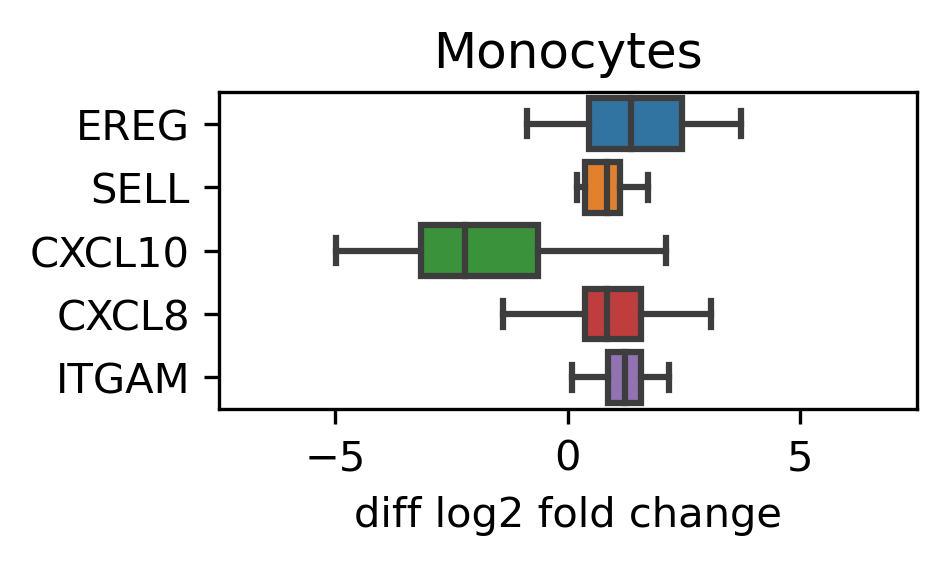

In [502]:
#ct_genes = ct.loc[m_dt['genes']].sort_values('med_pair').index

ct_genes = cts_ave_2.loc['Monocytes'].index.tolist()
pairwise_boxplot(ct_FC, ct_genes, 'Monocytes', fn + 'monocytes_box.png')

{'figure': <Figure size 900x630 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Classical monocytes'}, xlabel='diff log2 fold change'>}

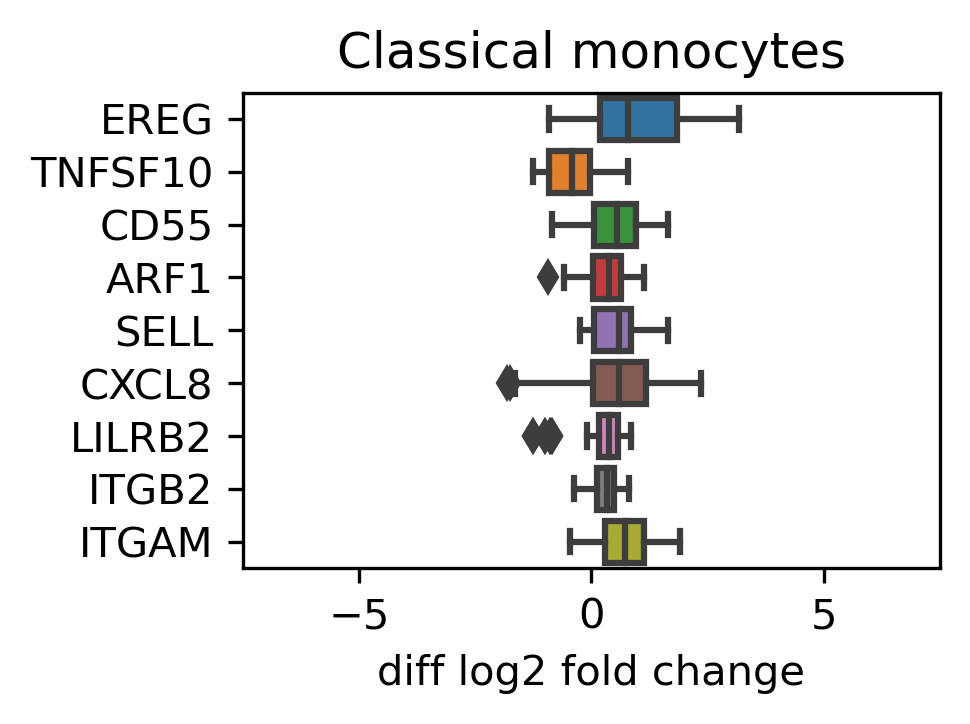

In [498]:
ct_genes = csts_ave_2.loc['Classical_monocytes'].index.tolist()
pairwise_boxplot(subct_FC.loc['Classical_monocytes'], ct_genes, 'Classical monocytes', fn + 'Classical_monocytes_box.png')

{'figure': <Figure size 900x540 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'non classical monocytes'}, xlabel='diff log2 fold change'>}

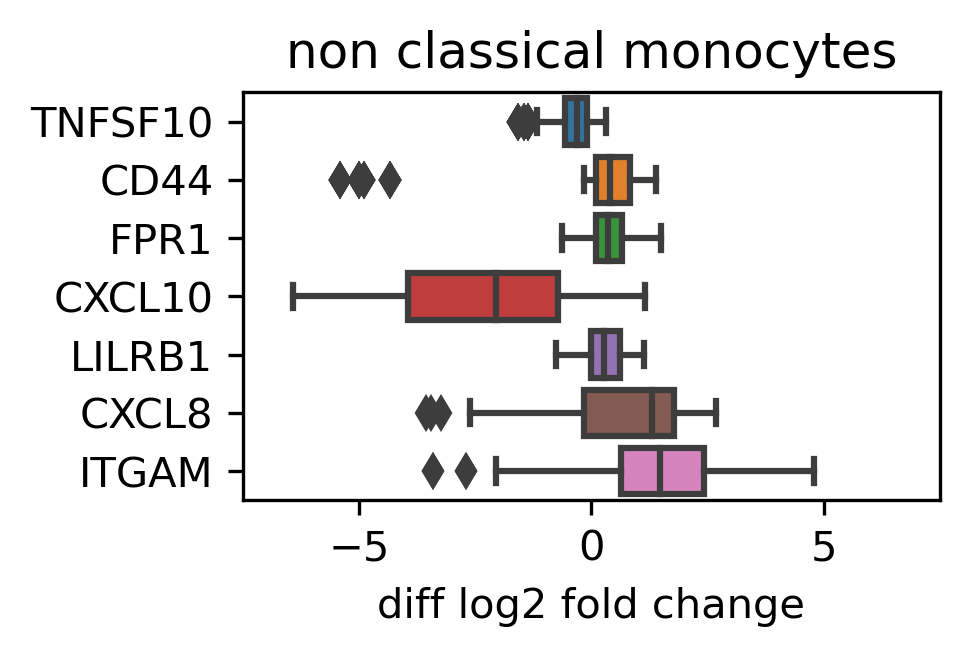

In [499]:
#ct_genes = ct.loc[ncm_dt['genes']].sort_values('med_pair').index

ct_genes = csts_ave_2.loc['non_classical_monocytes'].index.tolist()
pairwise_boxplot(subct_FC.loc['non_classical_monocytes'], ct_genes, 'non classical monocytes', fn + 'non_classical_monocytes_box.png')

{'figure': <Figure size 900x660 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Macrophages'}, xlabel='diff log2 fold change'>}

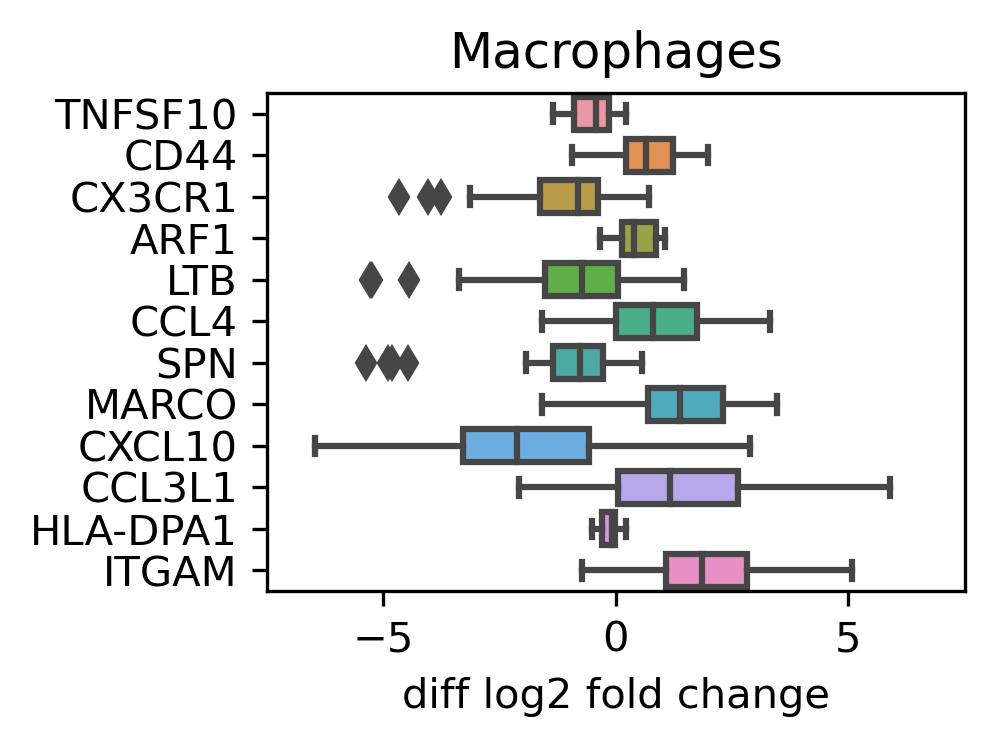

In [500]:
# less_genes = ct.loc[ma_dt['genes']][ct.loc[ma_dt['genes']]['log2_fold_change'] < 0].index.tolist()
# more_genes = ct.loc[ma_dt['genes']].sort_values('med_pair').tail(10).index.tolist() 

# ct_genes = less_genes + more_genes 
ct_genes = csts_ave_2.loc['Macrophages'].index.tolist()
pairwise_boxplot(subct_FC.loc['Macrophages'], ct_genes, 'Macrophages', fn + 'Macrophages_box.png')

In [4]:
from my_mushroom import s_mushrooms

In [5]:
ct_genes = []
subct_genes = []
for gene in ['CXCL10', 'IL1R2', 'CCL4', 'CXCL3', 'CXCL8', 'RETN', 'CXCL2']:
    ct_genes.append({gene: ['Monocytes']})
    subct_genes.append({gene: ['Classical_monocytes', 'non_classical_monocytes', 'Macrophages']})

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/yike/phd/dengue/dengue_children/my_mushroom.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1440 with 9 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

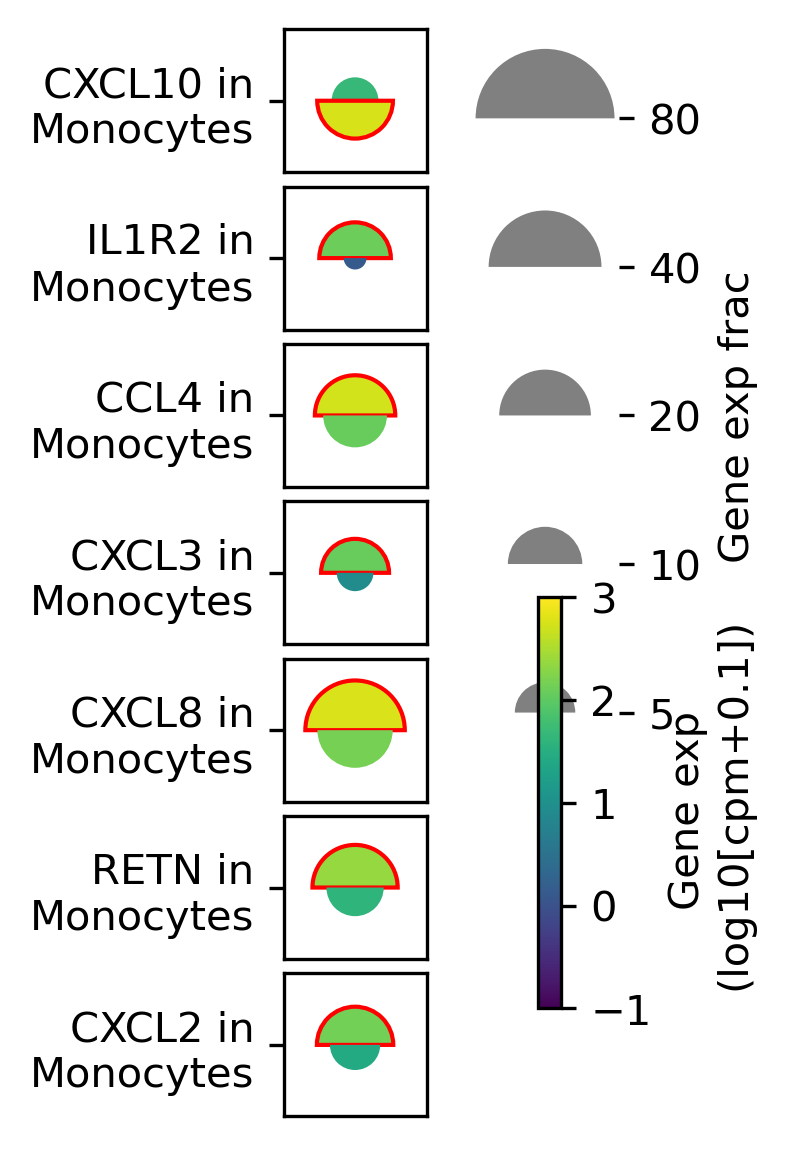

In [6]:
s_mushrooms(ct_genes)

<ipython-input-14-27a2bdb44184>:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-14-27a2bdb44184>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x3960 with 9 Axes>,
 'ax': [<AxesSubplot:title={'center':'CXCL10'}>,
  <AxesSubplot:title={'center':'IL1R2'}>,
  <AxesSubplot:title={'center':'CCL4'}>,
  <AxesSubplot:title={'center':'CXCL3'}>,
  <AxesSubplot:title={'center':'CXCL8'}>,
  <AxesSubplot:title={'center':'RETN'}>,
  <AxesSubplot:title={'center':'CXCL2'}>]}

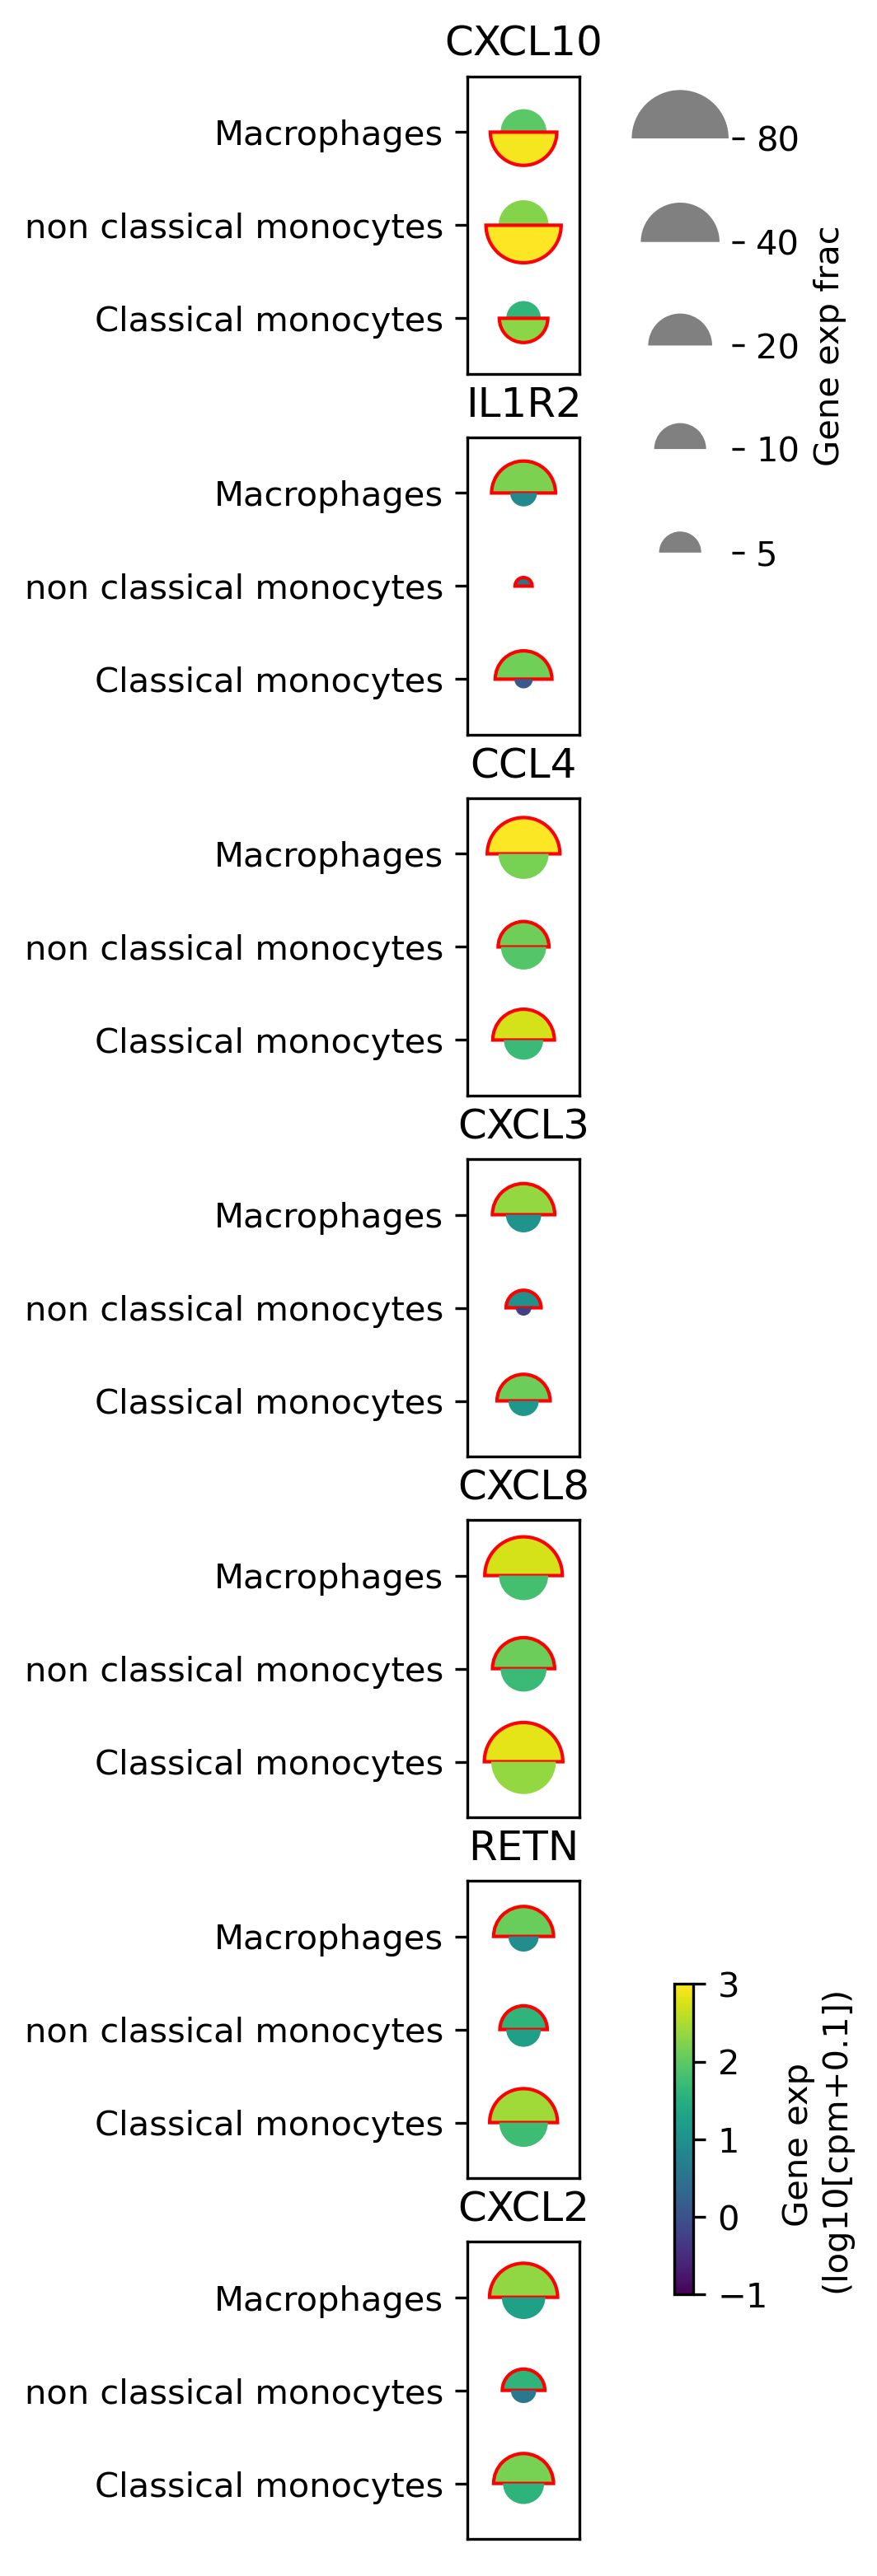

In [15]:
s_mushrooms(subct_genes)

In [32]:
adata_endo = sc.read_h5ad('/home/yike/phd/dataset_from_google/Tabula_Sapiens_Single_Cell_Dataset/TS_Endothelial.h5ad')

In [46]:
cds

Index(['capillary aerocyte', 'capillary endothelial cell', 'endothelial cell',
       'endothelial cell of artery', 'endothelial cell of lymphatic vessel',
       'endothelial cell of vascular tree', 'gut endothelial cell',
       'lung microvascular endothelial cell', 'vein endothelial cell'],
      dtype='object')

In [53]:
def fra_avg_endo(adata):    

    fra_avg = pd.DataFrame([])
    
    cts = adata.obs['Annotation'].astype('category').cat.categories    
    for ct in cts:
        adata_ct = adata[adata.obs['Annotation'] == ct]

        fra_ct = np.asarray((adata_ct.X > 0).mean(axis=0))[0]
        avg_ct = np.asarray(adata_ct.X.mean(axis=0))[0]
        fra_avg_ct = pd.DataFrame(avg_ct, columns=['avg'], index=adata_ct.var_names)
        fra_avg_ct['fra'] = fra_ct
        fra_avg_ct['cell_subtype'] = ct
        fra_avg = pd.concat([fra_avg, fra_avg_ct])
        fra_avg['gene'] = fra_avg.index.tolist()
            
    return fra_avg

fra_avg_endo = fra_avg_endo(adata_endo)
fra_avg_endo.to_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index=False)

In [67]:
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]
genes = np.unique(interactions)
print('filter interaction genes in immune and endo dataset')
im_genes = [i for i in genes if i in adata.var_names] 
ed_genes = [i for i in genes if i in adata_endo.var_names] 

Load interaction
filter interaction genes in immune and endo dataset


In [73]:
fra_avg_endo = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index_col=['cell_subtype', 'gene'])

In [108]:
def endo_cst_inters(cell_types, fra_n):
    inters_endo = []

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']

        for cell_type in cell_types:
            if cell_type == 'Monocytes':
                data = ct.loc[cell_type]
            else:
                data = subct.loc[cell_type]

            im_up = data[(data['log2_fold_change'] > 1) & (-np.log10(data['pvalue']) > 2) & (data['S_fra'] > fra_n)].index
            im_down = data[(data['log2_fold_change'] < -1) & (-np.log10(data['pvalue']) > 2) & (data['NS_fra'] > fra_n)].index

            for ed_ct in adata_endo.obs['Annotation'].astype('category').cat.categories:
                fra_ed = {gene: fra_avg_endo.loc[ed_ct].loc[gene]['fra'] for gene in [ga, gb] if gene in ed_genes} 
                avg_ed = {gene: fra_avg_endo.loc[ed_ct].loc[gene]['avg'] for gene in [ga, gb] if gene in ed_genes} 

                if gb not in adata_endo.var_names:
                        continue
                elif (ga in im_up) & (fra_ed[gb] > fra_n):
                    inters_endo.append([ga, cell_type, gb, ed_ct] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'up'])
                elif (ga in im_down) & (fra_ed[gb] > fra_n):
                    inters_endo.append([ga, cell_type, gb, ed_ct] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'down'])

                if ga not in adata_endo.var_names:
                        continue
                elif (gb in im_up) & (fra_ed[ga] > fra_n):
                    inters_endo.append([gb, cell_type, ga, ed_ct] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'up'])
                elif (gb in im_down) & (fra_ed[ga] > fra_n):
                    inters_endo.append([gb, cell_type, ga, ed_ct] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'down'])

    inters_endo = pd.DataFrame(inters_endo, columns=['ga', 'cta', 'gb', 'ctb'] + ct.columns.tolist() + ['endo_fra', 'endo_avg', 'inter_type'])
    
    return inters_endo

In [122]:
inters_mo_ct = endo_cst_inters(['Monocytes'], 0.05)
inters_mo_ct.to_csv('/home/yike/phd/dengue/data/tables/endos/endo_cst_mo_ct005.tsv', sep='\t', index=False)

inters_mo_cst = endo_cst_inters(['Classical_monocytes', 'non_classical_monocytes', 'Macrophages'], 0.05)
inters_mo_cst.to_csv('/home/yike/phd/dengue/data/tables/endos/endo_cst_mo_cst005.tsv', sep='\t', index=False)

In [260]:
def endo_inters(cell_types, fra_n):
    
    fra = np.asarray((adata_endo.X > 0).mean(axis=0))[0]
    avg = np.asarray(adata_endo.X.mean(axis=0))[0]
    fra_avg_endo = pd.DataFrame(avg, columns=['avg'], index=adata_endo.var_names)
    fra_avg_endo['fra'] = fra
    
    inters_endo = []

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']

        for cell_type in cell_types:
            if cell_type == 'Monocytes':
                data = ct.loc[cell_type]
            else:
                data = subct.loc[cell_type]

            im_up = data[(data['log2_fold_change'] > 1) & (-np.log10(data['pvalue']) > 2) & (data['S_fra'] > fra_n)].index
            im_down = data[(data['log2_fold_change'] < -1) & (-np.log10(data['pvalue']) > 2) & (data['NS_fra'] > fra_n)].index

            fra_ed = {gene: fra_avg_endo.loc[gene]['fra'] for gene in [ga, gb] if gene in ed_genes} 
            avg_ed = {gene: fra_avg_endo.loc[gene]['avg'] for gene in [ga, gb] if gene in ed_genes} 

            if gb not in adata_endo.var_names:
                continue
            elif (ga in im_up) & (fra_ed[gb] > fra_n):
                inters_endo.append([ga, cell_type, gb] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'up'])
            elif (ga in im_down) & (fra_ed[gb] > fra_n):
                inters_endo.append([ga, cell_type, gb] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'down'])

            if ga not in adata_endo.var_names:
                continue
            elif (gb in im_up) & (fra_ed[ga] > fra_n):
                inters_endo.append([gb, cell_type, ga] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'up'])
            elif (gb in im_down) & (fra_ed[ga] > fra_n):
                inters_endo.append([gb, cell_type, ga] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'down'])

    inters_endo = pd.DataFrame(inters_endo, columns=['ga', 'cta', 'gb'] + ct.columns.tolist() + ['endo_fra', 'endo_avg', 'inter_type'])
    
    return inters_endo

In [123]:
inters_mo_ct_ave = endo_inters(['Monocytes'], 0.05)
inters_mo_ct_ave.to_csv('/home/yike/phd/dengue/data/tables/endos/endo_mo_ct005.tsv', sep='\t', index=False)

inters_mo_cst_ave = endo_inters(['Classical_monocytes', 'non_classical_monocytes', 'Macrophages'], 0.05)
inters_mo_cst_ave.to_csv('/home/yike/phd/dengue/data/tables/endos/endo_mo_cst005.tsv', sep='\t', index=False)

In [125]:
inters_mo_ct.set_index(['ga', 'cta', 'gb', 'ctb'], inplace=True)
inters_mo_cst.set_index(['ga', 'cta', 'gb', 'ctb'], inplace=True)

inters_mo_ct_ave.set_index(['ga', 'cta', 'gb'], inplace=True)
inters_mo_cst_ave.set_index(['ga', 'cta', 'gb'], inplace=True)

In [145]:
inters_ct = inters_mo_ct[(inters_mo_ct['med_pair'] > 1) | (inters_mo_ct['med_pair'] < -1)]
inters_ct

med_pair  \
ga     cta       gb    ctb                                              
EREG   Monocytes EGFR  capillary aerocyte                    1.367064   
                       capillary endothelial cell            1.367064   
                       endothelial cell                      1.367064   
                       endothelial cell of artery            1.367064   
                       lung microvascular endothelial cell   1.367064   
                       vein endothelial cell                 1.367064   
CXCL10 Monocytes DPP4  endothelial cell                     -2.219462   
                       endothelial cell of lymphatic vessel -2.219462   
                       gut endothelial cell                 -2.219462   
ITGAM  Monocytes C3    endothelial cell of lymphatic vessel  1.216926   
                 ICAM1 capillary aerocyte                    1.216926   
                       capillary endothelial cell            1.216926   
                       endothelial cell                      1.216926   
                       endothelial cell of artery            1.216926   
                       endothelial cell of lymphatic vessel  1.216926   
                       endothelial cell of vascular tree     1.216926   
                       gut endothelial cell                  1.216926   
                       lung microvascular endothelial cell   1.216926   
                       vein endothelial cell                 1.216926   
                 JAM3  capillary aerocyte                    1.216926   
                       capillary endothelial cell            1.216926   
                       endothelial cell                      1.216926   
                       endothelial cell of artery            1.216926   
                       endothelial cell of vascular tree     1.216926   
                       gut endothelial cell                  1.216926   
                       lung microvascular endothelial cell   1.216926   
                       vein endothelial cell                 1.216926   

                                                             fra_pair  \
ga     cta       gb    ctb                                              
EREG   Monocytes EGFR  capillary aerocyte                       0.875   
                       capillary endothelial cell               0.875   
                       endothelial cell                         0.875   
                       endothelial cell of artery               0.875   
                       lung microvascular endothelial cell      0.875   
                       vein endothelial cell                    0.875   
CXCL10 Monocytes DPP4  endothelial cell                         0.125   
                       endothelial cell of lymphatic vessel     0.125   
                       gut endothelial cell                     0.125   
ITGAM  Monocytes C3    endothelial cell of lymphatic vessel     1.000   
                 ICAM1 capillary aerocyte                       1.000   
                       capillary endothelial cell               1.000   
                       endothelial cell                         1.000   
                       endothelial cell of artery               1.000   
                       endothelial cell of lymphatic vessel     1.000   
                       endothelial cell of vascular tree        1.000   
                       gut endothelial cell                     1.000   
                       lung microvascular endothelial cell      1.000   
                       vein endothelial cell                    1.000   
                 JAM3  capillary aerocyte                       1.000   
                       capillary endothelial cell               1.000   
                       endothelial cell                         1.000   
                       endothelial cell of artery               1.000   
                       endothelial cell of vascular tree        1.000   
                       gut endothelial cell  

In [146]:
inters_cst = inters_mo_cst[(inters_mo_cst['med_pair'] > 1) | (inters_mo_cst['med_pair'] < -1)]
inters_cst[:53]

med_pair  \
ga     cta                     gb      ctb                                              
EREG   Macrophages             EGFR    capillary aerocyte                    1.665314   
                                       capillary endothelial cell            1.665314   
                                       endothelial cell                      1.665314   
                                       endothelial cell of artery            1.665314   
                                       lung microvascular endothelial cell   1.665314   
                                       vein endothelial cell                 1.665314   
MARCO  Macrophages             SCGB3A1 capillary aerocyte                    1.372773   
                                       capillary endothelial cell            1.372773   
                                       endothelial cell                      1.372773   
                                       endothelial cell of artery            1.372773   
                                       endothelial cell of lymphatic vessel  1.372773   
                                       lung microvascular endothelial cell   1.372773   
                                       vein endothelial cell                 1.372773   
CXCL10 non_classical_monocytes DPP4    endothelial cell                     -2.054633   
                                       endothelial cell of lymphatic vessel -2.054633   
                                       gut endothelial cell                 -2.054633   
       Macrophages             DPP4    endothelial cell                     -2.124290   
                                       endothelial cell of lymphatic vessel -2.124290   
                                       gut endothelial cell                 -2.124290   
CCL3L1 non_classical_monocytes DPP4    endothelial cell                      1.054335   
                                       endothelial cell of lymphatic vessel  1.054335   
                                       gut endothelial cell                  1.054335   
       Macrophages             DPP4    endothelial cell                      1.172174   
                                       endothelial cell of lymphatic vessel  1.172174   
                                       gut endothelial cell                  1.172174   
       non_classical_monocytes ACKR2   endothelial cell of lymphatic vessel  1.054335   
                                       gut endothelial cell                  1.054335   
       Macrophages             ACKR2   endothelial cell of lymphatic vessel  1.172174   
                                       gut endothelial cell                  1.172174   
CXCL8  non_classical_monocytes ACKR1   capillary endothelial cell            1.311897   
                                       endothelial cell                      1.311897   
                                       endothelial cell of artery            1.311897   
                                       endothelial cell of vascular tree     1.311897   
                                       gut endothelial cell                  1.311897   
                                       lung microvascular endothelial cell   1.311897   
                                       vein endothelial cell                 1.311897   
       Macrophages             ACKR1   capillary endothelial cell            1.448968   
                                       endothelial cell                      1.448968   
                                       endothelial cell of artery            1.448968   
                                       endothelial cell of vascular tree     1.448968   
                                       gut endothelial cell                  1.448968   
                                       lung microvascular endothelial cell   1.448968   
                                       vein endothelial cell                 1.448968   
MS4A4A Classical_monocytes     NRG1    endothelial cell                 

In [147]:
inters_cst[54:]

med_pair  \
ga     cta                     gb    ctb                                              
CCL4L2 Macrophages             VSIR  capillary endothelial cell            1.257172   
                                     endothelial cell                      1.257172   
                                     endothelial cell of artery            1.257172   
                                     endothelial cell of lymphatic vessel  1.257172   
                                     endothelial cell of vascular tree     1.257172   
                                     gut endothelial cell                  1.257172   
                                     lung microvascular endothelial cell   1.257172   
                                     vein endothelial cell                 1.257172   
ITGAM  non_classical_monocytes C3    endothelial cell of lymphatic vessel  1.472028   
       Macrophages             C3    endothelial cell of lymphatic vessel  1.854823   
       non_classical_monocytes ICAM1 capillary aerocyte                    1.472028   
                                     capillary endothelial cell            1.472028   
                                     endothelial cell                      1.472028   
                                     endothelial cell of artery            1.472028   
                                     endothelial cell of lymphatic vessel  1.472028   
                                     endothelial cell of vascular tree     1.472028   
                                     gut endothelial cell                  1.472028   
                                     lung microvascular endothelial cell   1.472028   
                                     vein endothelial cell                 1.472028   
       Macrophages             ICAM1 capillary aerocyte                    1.854823   
                                     capillary endothelial cell            1.854823   
                                     endothelial cell                      1.854823   
                                     endothelial cell of artery            1.854823   
                                     endothelial cell of lymphatic vessel  1.854823   
                                     endothelial cell of vascular tree     1.854823   
                                     gut endothelial cell                  1.854823   
                                     lung microvascular endothelial cell   1.854823   
                                     vein endothelial cell                 1.854823   
       non_classical_monocytes JAM3  capillary aerocyte                    1.472028   
                                     capillary endothelial cell            1.472028   
                                     endothelial cell                      1.472028   
                                     endothelial cell of artery            1.472028   
                                     endothelial cell of vascular tree     1.472028   
                                     gut endothelial cell                  1.472028   
                                     lung microvascular endothelial cell   1.472028   
                                     vein endothelial cell                 1.472028   
       Macrophages             JAM3  capillary aerocyte                    1.854823   
                                     capillary endothelial cell            1.854823   
                                     endothelial cell                      1.854823   
                                     endothelial cell of artery            1.854823   
                                     endothelial cell of vascular tree     1.854823   
                                     gut endothelial cell                  1.854823   
                                     lung microvascular endothelial cell   1.854823   
                                     vein endothelial cell                 1.854823   

                                                                        

In [148]:
inters_ct_ave = inters_mo_ct_ave[(inters_mo_ct_ave['med_pair'] > 1) | (inters_mo_ct_ave['med_pair'] < -1)]
inters_ct_ave

med_pair  fra_pair     S_fra    NS_fra     S_avg  \
ga    cta       gb                                                        
EREG  Monocytes EGFR   1.367064     0.875  0.181419  0.024549  1.621969   
ITGAM Monocytes ICAM1  1.216926     1.000  0.263580  0.098195  2.175136   
                JAM3   1.216926     1.000  0.263580  0.098195  2.175136   

                         NS_avg  statistic        pvalue      avg1      avg2  \
ga    cta       gb                                                             
EREG  Monocytes EGFR   0.221196   0.156871  4.472917e-25  0.221196  1.621968   
ITGAM Monocytes ICAM1  0.848345   0.165385  7.719480e-28  0.848345  2.175134   
                JAM3   0.848345   0.165385  7.719480e-28  0.848345  2.175134   

                       log2_fold_change  endo_fra  endo_avg inter_type  
ga    cta       gb                                                      
EREG  Monocytes EGFR           1.400773  0.119937  0.285886         up  
ITGAM Monocytes ICAM1          1.326789  0.581976  1.437551         up  
                JAM3           1.326789  0.243297  0.820489         up

In [237]:
inters_cst_ave = inters_mo_cst_ave[(inters_mo_cst_ave['med_pair'] > 1) | (inters_mo_cst_ave['med_pair'] < -1)]

In [267]:
cts_ave_2 = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/endo_mo_ct002.tsv', sep='\t', index_col=['cta', 'ga', 'gb'])

In [446]:
cts_ave_2 = cts_ave_2[(cts_ave_2['fra_pair'] >= 0.75) | (cts_ave_2['fra_pair'] <= 0.25)]
cts_ave_2

gb  med_pair  fra_pair     S_fra    NS_fra     S_avg  \
cta       ga                                                                
Monocytes EREG     EGFR  1.367064    0.8750  0.181419  0.024549  1.621969   
          SELL     CD34  0.835037    1.0000  0.627780  0.340072  5.728765   
          CXCL10   DPP4 -2.219462    0.1250  0.043880  0.235379  0.398741   
          SELL    PODXL  0.835037    1.0000  0.627780  0.340072  5.728765   
          CXCL8   ACKR1  0.849409    0.8125  0.550310  0.224549  5.345046   
          ITGAM   ICAM1  1.216926    1.0000  0.263580  0.098195  2.175136   
          ITGAM    JAM3  1.216926    1.0000  0.263580  0.098195  2.175136   

                    NS_avg  statistic         pvalue      avg1      avg2  \
cta       ga                                                               
Monocytes EREG    0.221196   0.156871   4.472917e-25  0.221196  1.621968   
          SELL    3.049778   0.287708   2.106173e-84  3.049778  5.728764   
          CXCL10  2.441285   0.195957   5.362721e-39  2.441284  0.398741   
          SELL    3.049778   0.287708   2.106173e-84  3.049778  5.728764   
          CXCL8   2.065545   0.325761  1.105747e-108  2.065545  5.345045   
          ITGAM   0.848345   0.165385   7.719480e-28  0.848345  2.175134   
          ITGAM   0.848345   0.165385   7.719480e-28  0.848345  2.175134   

                  log2_fold_change  endo_fra  endo_avg inter_type  
cta       ga                                                       
Monocytes EREG            1.400773  0.119937  0.285886         up  
          SELL            2.678986  0.682786  1.823173         up  
          CXCL10         -2.042544  0.024889  0.096349       down  
          SELL            2.678986  0.635430  2.021903         up  
          CXCL8           3.279500  0.548066  1.993051         up  
          ITGAM           1.326789  0.581976  1.437551         up  
          ITGAM           1.326789  0.243297  0.820489         up

In [444]:
csts_ave_2 = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/endo_mo_cst002.tsv', sep='\t', index_col=['cta', 'ga', 'gb'])

In [447]:
csts_ave_2 = csts_ave_2[(csts_ave_2['fra_pair'] >= 0.75) | (csts_ave_2['fra_pair'] <= 0.25)]
csts_ave_2

med_pair  fra_pair     S_fra  \
cta                     ga      gb                                        
Classical_monocytes     EREG    EGFR       0.794877  0.750000  0.186669   
                        TNFSF10 TNFRSF10A -0.409407  0.250000  0.506649   
non_classical_monocytes TNFSF10 TNFRSF10A -0.299037  0.178571  0.818182   
Macrophages             TNFSF10 TNFRSF10A -0.416902  0.107143  0.637566   
non_classical_monocytes CD44    SPP1       0.398534  0.785714  0.538462   
...                                             ...       ...       ...   
Macrophages             ITGAM   ICAM1      1.854823  0.964286  0.285714   
Classical_monocytes     ITGB2   JAM3       0.338850  0.875000  0.845312   
                        ITGAM   JAM3       0.725449  0.875000  0.262582   
non_classical_monocytes ITGAM   JAM3       1.472028  0.857143  0.258741   
Macrophages             ITGAM   JAM3       1.854823  0.964286  0.285714   

                                             NS_fra     S_avg     NS_avg  \
cta                     ga      gb                                         
Classical_monocytes     EREG    EGFR       0.036322  1.673379   0.330178   
                        TNFSF10 TNFRSF10A  0.675369  4.541181   6.644274   
non_classical_monocytes TNFSF10 TNFRSF10A  0.933862  7.620702  10.075921   
Macrophages             TNFSF10 TNFRSF10A  0.928571  5.672342   9.667793   
non_classical_monocytes CD44    SPP1       0.325397  4.446918   2.815556   
...                                             ...       ...        ...   
Macrophages             ITGAM   ICAM1      0.095238  2.226711   0.812333   
Classical_monocytes     ITGB2   JAM3       0.695800  8.313285   6.705152   
                        ITGAM   JAM3       0.122588  2.180089   1.059584   
non_classical_monocytes ITGAM   JAM3       0.042328  2.034492   0.368017   
Macrophages             ITGAM   JAM3       0.095238  2.226711   0.812333   

                                           statistic        pvalue       avg1  \
cta                     ga      gb                                              
Classical_monocytes     EREG    EGFR        0.150347  1.336686e-15   0.330178   
                        TNFSF10 TNFRSF10A   0.296782  2.214991e-60   6.644275   
non_classical_monocytes TNFSF10 TNFRSF10A   0.530585  2.382682e-43  10.075919   
Macrophages             TNFSF10 TNFRSF10A   0.572616  5.192753e-30   9.667794   
non_classical_monocytes CD44    SPP1        0.211189  7.317823e-07   2.815556   
...                                              ...           ...        ...   
Macrophages             ITGAM   ICAM1       0.188226  2.037664e-03   0.812333   
Classical_monocytes     ITGB2   JAM3        0.171871  2.791457e-20   6.705152   
                        ITGAM   JAM3        0.139994  1.479927e-13   1.059584   
non_classical_monocytes ITGAM   JAM3        0.215512  3.959720e-07   0.368017   
Macrophages             ITGAM   JAM3        0.188226  2.037664e-03   0.812333   

                                               avg2  log2_fold_change  \
cta                     ga      gb                                      
Classical_monocytes     EREG    EGFR       1.673379          1.343201   
                        TNFSF10 TNFRSF10A  4.541185         -2.103090   
non_classical_monocytes TNFSF10 TNFRSF10A  7.633540         -2.442379   
Macrophages             TNFSF10 TNFRSF10A  5.652930         -4.014864   
non_classical_monocytes CD44    SPP1       4.431424          1.615869   
...                                             ...               ...   
Macrophages             ITGAM   ICAM1      2.209178          1.396845   
Classical_monocytes     ITGB2   JAM3       8.313280          1.608129   
                        ITGAM   JAM3       2.180088          1.120504   
non_classical_monocytes ITGAM   JAM3       2.027402          1.659385   
Macrophages             ITGAM   JAM3       2.209178          1.396845   

                                           endo_fra  endo_avg inter_type  